In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sps
import scipy.optimize
from tqdm import tqdm
import scipy.special

%matplotlib inline

Посчитаем интегралы, взяв в кач-ве априорных распределений сопряженные $\\Beta(\alpha_0, \beta)$ и $\Gamma(\alpha_1, \theta)$ распределения соответствено(с некоторыми параметрами)

$$K(X) = \frac{\mathsf{P}(\left. \mathcal{P}_0 \right| X)}{\mathsf{P}(\left. \mathcal{P}_1 \right| X)} = \frac{\int\limits_\Theta p^0_\theta(X) q^0(\theta) d\theta}{\int\limits_\Sigma p^1_\sigma(X) q^1(\sigma) d\sigma}$$

 $p^0(X) = \int\limits_{0}^{1} (\Pi C_m^{x_i}) p^{\sum{x_i}}(1 - p)^{mn - \sum{x_i}} \cdot \frac{ p^{\alpha - 1} (1 - p)^{\beta - 1} } {B(\alpha, \beta)} dp = \frac{(\Pi C_m^{x_i}) \cdot B(\sum{x_i} + \alpha, mn - \sum{x_i} + \beta)} {{B(\alpha, \beta)}}$ - Бета функция

$p^1(X) = \int\limits_{0}^{+\infty} \Pi(\frac{e^{-\lambda} \cdot \lambda^{x_i}} {x_i!} ) \cdot \frac{\theta^{\alpha} \lambda^{\alpha - 1} e^{-\theta \lambda}} {\Gamma{(\alpha)}} d\lambda = \frac{\theta^\alpha}{(\Pi x_i!) \cdot \Gamma{(\alpha)}} \cdot \int\limits_{0}^{+\infty} e^{-\lambda(\theta + n)} \lambda^{\sum{x_i} + \alpha - 1 }d\lambda $ = / преобразуем подинтегральную фунеции так, чтобы она стала Гамма функцией /= $\frac{\theta^\alpha}{(\Pi x_i!) \cdot \Gamma{(\alpha)}} \cdot \frac{1}{(\theta + n)^{\sum{x_i} + \alpha}} \cdot \Gamma(\sum{x_i} + \alpha)$ 

In [109]:
m = 10
p = 1 / 3
alpha = 2
beta = 3

In [117]:
alpha_1 = 2
theta = 3

In [110]:
confidences = [0.01, 0.05, 0.1]
sample_sizes = [100, 250, 500]

In [111]:
sample = sps.binom.rvs(m, p, size=sample_sizes[0])

In [112]:
sample

array([4, 0, 3, 2, 5, 5, 2, 3, 4, 5, 4, 3, 2, 2, 2, 3, 5, 4, 4, 5, 2, 4, 6,
       5, 3, 3, 1, 4, 4, 5, 3, 4, 1, 3, 3, 3, 3, 1, 4, 6, 3, 5, 3, 4, 5, 2,
       5, 1, 4, 3, 6, 2, 5, 3, 1, 2, 4, 4, 3, 3, 3, 3, 4, 5, 4, 4, 5, 4, 7,
       3, 4, 3, 2, 2, 3, 1, 0, 2, 5, 2, 4, 4, 3, 4, 2, 5, 3, 5, 5, 6, 2, 3,
       3, 2, 1, 1, 3, 2, 3, 5])

In [131]:
chis = np.sum(np.log(scipy.special.binom(10, sample))) - scipy.special.betaln(alpha, beta) + scipy.special.betaln(sum(sample) + alpha, m * len(sample) - sum(sample) + beta)

In [130]:
znam = alpha_1 * np.log(theta) - (np.sum(np.log(scipy.special.factorial(sample))) +
                    scipy.special.gammaln(alpha_1)) +  scipy.special.gammaln(sum(sample) + alpha_1)\
                - np.log(theta + len(sample)) * (sum(sample) + alpha_1)

In [161]:
K = chis - znam
K

7.8644289397595912

In [160]:
K_stats = []
for ss in (sample_sizes):
    to_add = []
    for i in tqdm(range(int(1e5))):
        sample = sps.binom.rvs(m, p, size=sample_sizes[0])
        chis = np.sum(np.log(scipy.special.binom(10, sample))) \
                    - scipy.special.betaln(alpha, beta) \
                    + scipy.special.betaln(sum(sample) \
                    + alpha, m * len(sample) - sum(sample) + beta)
            
            
        znam = alpha_1 * np.log(theta) - (np.sum(np.log(scipy.special.factorial(sample))) +
                    scipy.special.gammaln(alpha_1)) +  scipy.special.gammaln(sum(sample) + alpha_1)\
                - np.log(theta + len(sample)) * (sum(sample) + alpha_1)
            
            
        K_stat =  chis - znam
        to_add.append(K_stat)
    K_stats.append(to_add)

100%|██████████| 100000/100000 [00:19<00:00, 5085.13it/s]


Посчитали нашу статистику, теперь возьмем и посмотрим на гистограммы этого распределения

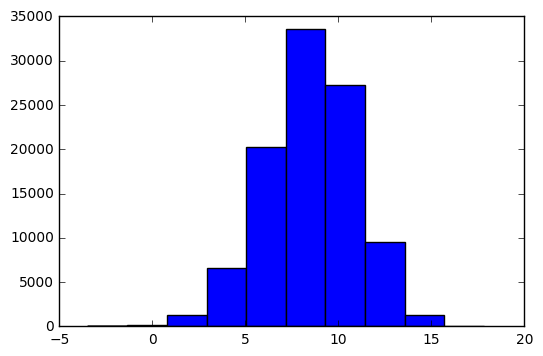

In [162]:
plt.hist(K_stats[0])
plt.show()

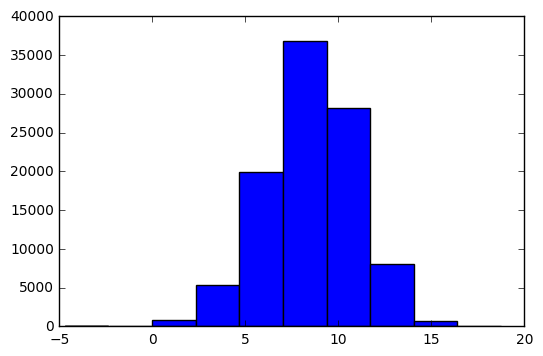

In [163]:
plt.hist(K_stats[1])
plt.show()

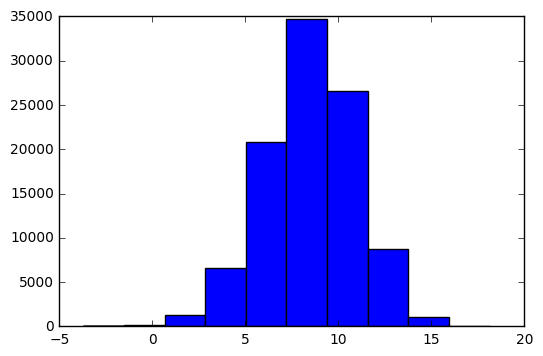

In [164]:
plt.hist(K_stats[2])
plt.show()

Теперь, для того чтобы получить нужный уровень значимости, осталось найти выборочные квантили этого распределения разных уровней.

In [165]:
quantiles = []
for conf in tqdm(confidences):
    to_add = []
    for stat in K_stats:
        quant = np.percentile(stat, 1 - conf)
        to_add.append(quant)
    quantiles.append(to_add)

100%|██████████| 3/3 [00:00<00:00, 23.78it/s]


In [166]:
quantiles

[[2.532422750961425, 2.43787236676549, 2.454395833583908],
 [2.48180457940623, 2.3877251699571955, 2.397224044009636],
 [2.4184024463206626, 2.3312706945447754, 2.3278362212444312]]

Вот мы получили наши квантили(критические значения), для всех заданных в условии параметрах

In [167]:
print ('conf size  val')
for i in range(3):
    for j in range(3):
        print(confidences[i], sample_sizes[j], quantiles[i][j])

conf size  val
0.01 100 2.53242275096
0.01 250 2.43787236677
0.01 500 2.45439583358
0.05 100 2.48180457941
0.05 250 2.38772516996
0.05 500 2.39722404401
0.1 100 2.41840244632
0.1 250 2.33127069454
0.1 500 2.32783622124
